# MPT for Asset Selection

[Modern Portfolio Theory or MPT](https://www.investopedia.com/terms/m/modernportfoliotheory.asp#:~:text=A%20key%20component%20of%20the,their%20individual%20tolerance%20to%20risk) is a method of selecting the optimial proportions for a number of assets to hold in a investor's portfolio. This method is also widely referred to as "Mean-variance analysis" and involves selecting asset proportions based on their position in the "efficient frontier" (a 2D space of standard deviations of returns plotted against acutal returns). 


This notebook showcases an example workflow of using the Provided Utils in the MPT_Selection Library, it runs simulations using MPT, plots those sims in the space of Portfolios and can run "Forward Selection" on a number of Assets to Generate Sample Allocations for Optimial Portfolios given a set of Investments and their returns

Misc Links & Notes: 
- MPT by The Balance- https://www.thebalance.com/what-is-mpt-2466539

- the "Efficient Frontier" in the Graphical sense, displays the optimial line of possible portfolios (combination of asset allocations that comprise an investors holdings) -- wherein we maximize returns for the amount of risk incurred (returns are dependent on the allocations within the portfolio, the efficient frontier displays the optimal portfolios and their weights for tradeoffs, everything to the right of the frontier provides suboptimal returns for the risk incurred)
  - Efficient frontier assumes that returns follow a normal dist, but in the Crypto world the normal event seems to be black swan events, assumptions behind MPT do not really hold up so applying it to the space is a bit shifty

In [1]:
# Example of Determining Optimal Allocation (Daily Adjusted Returns, Jan of 2022)
import pandas as pd 


table_list = ["ATOMUSDT-1m-2020-09.csv", "ATOMUSDT-1m-2020-10.csv", "BTCUSDT-1m-2020-09.csv", "BTCUSDT-1m-2020-10.csv", "ETHUSDT-1m-2020-09.csv","ETHUSDT-1m-2020-10.csv", "MATICUSDT-1m-2020-09.csv", "MATICUSDT-1m-2020-10.csv", "SOLUSDT-1m-2020-09.csv", "SOLUSDT-1m-2020-10.csv"]
#Flat Files in OHLC+V Data Schema

colnames = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'] #Binance Column Names -- schema for provided dataset

# Multi-Reading dfs -- Convert Data to Input for MPT Simulation
for table in table_list: 
    df = pd.read_csv(f"data/{table}", index_col=None, names=colnames) #iterative read, will subset later

    # Convert to PandasFrame, Compute Return & Drop Columns
    # df["return"] = ((df["close"]-df["open"])/df["open"])*100 #return for 1m period, in percentage - calc returns w ".pct_change()" a df method
    # df = df[["open_time", "return"]] #filter out the remaining columns
    
    df["close"] = (df["close"]-df["close"].min())/(df["close"].max()-df["close"].min()) #scale closing price!
    df = df[["open_time", "close"]] #return close price, will calc returns with percentage change later

    # Add Ticker Symbol (for differentiating in Aggregated df)
    crypto_name = table.split("USDT") #split on quoted asset name, get unique crypto "ticker"
    df["name"] = crypto_name[0]
    
    # Append to Group Table -- Returns per Crypto for timeperiod
    if table == table_list[0]:
        dfr = df #starting asset
    else: 
        dfr = pd.concat([dfr, df], axis=0, ignore_index=True) #appending to aggregated frame


# Print out Final Shape
print("dfr's shape: ", dfr.shape) #should come out to be (9967553, 3)


# Aggregate Columns along Timestamp Axis
dfr = dfr.set_index("open_time")

# Set Cryptos as Columns (returns as values per timestamp)
table = dfr.pivot(columns='name')
table.columns = [col[1] for col in table.columns] #asset names for each column (else is a nested list with return included)

# Aggregate Timestamps to Daily Values
table.index = pd.to_datetime(table.index, unit='ms') #convert Unix Timestamp to pd datetime

table = table.resample('D').mean() #takes average daily price change as aggregated val

# Remove last day (1st of 2022 is included as second doesn't exclude 2022)
table = table.iloc[:-1, :]


table #returns the daily average prices per crypto, actual timestamps not needed for abstracted determination of which assets to be exposed to & in what capacity -- daily price movements are sufficient

dfr's shape:  (439200, 3)


,ATOM,BTC,ETH,MATIC,SOL
open_time,,,,,
2020-09-01,0.918772,0.915754,0.863245,0.928540,0.879087
2020-09-02,0.800661,0.779604,0.799592,0.719721,0.705902
2020-09-03,0.576382,0.530568,0.613578,0.512870,0.652417
2020-09-04,0.381464,0.230428,0.431512,0.204952,0.509914
2020-09-05,0.364391,0.177308,0.275445,0.176743,0.291782
2020-09-06,0.310044,0.146643,0.179261,0.122726,0.231813
2020-09-07,0.297332,0.127851,0.192183,0.115498,0.239331
2020-09-08,0.305444,0.121538,0.172347,0.132840,0.159926
2020-09-09,0.363056,0.139142,0.193872,0.215346,0.272288


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 8.54
Annualized Volatility: 3.63


            ATOM    BTC   ETH  MATIC   SOL
allocation  1.31  72.28  8.38  11.02  7.01
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 5.26
Annualized Volatility: 3.29


             ATOM    BTC   ETH  MATIC    SOL
allocation  22.83  53.64  0.98    1.9  20.66


(            ATOM    BTC   ETH  MATIC   SOL
 allocation  1.31  72.28  8.38  11.02  7.01,
              ATOM    BTC   ETH  MATIC    SOL
 allocation  22.83  53.64  0.98    1.9  20.66)

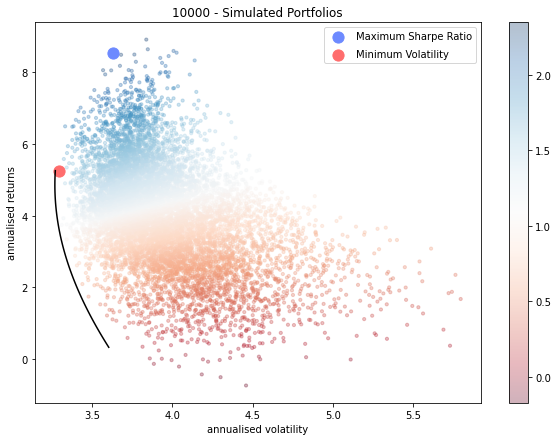

In [2]:
from MPT import *


returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 10000 #number of randomly generated portfolio weights
risk_free_rate = 0.0135 #rough average for 2021-2022 (for 10-YR US Treasury, typically used as RFR proxy in Finance)

SimulatePortfoliosAndPlot(table, num_portfolios=num_portfolios, rfr=risk_free_rate, plot_efficient_frontier=True)

In [3]:
# Non-Plotting Variation of Simulator -- roughly 2x faster than plot variant

MSR_allocation, MSR_metrics, MV_allocation, MV_metrics = OptimalPortfolioSim(table, num_portfolios=int(5e4), rfr=0.0135)
MSR_allocation #pandasframe, second object is dict of Portfolio Level Returns

,ATOM,BTC,ETH,MATIC,SOL
allocation,0.04,0.83,0.02,0.08,0.03


Text(0, 0.5, 'Price in USDT')

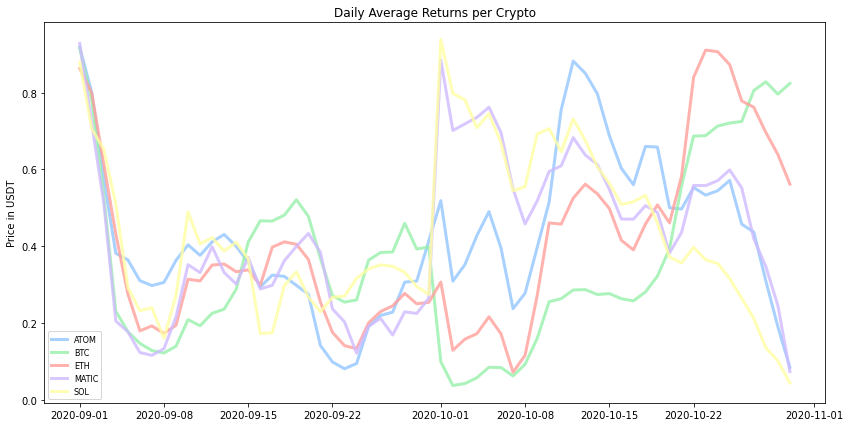

In [4]:
# Plot Returns for All Assets for Time Period
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')

plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8, label=c) #filter based on ticker name

plt.title("Daily Average Returns per Crypto")
plt.legend(loc='best', fontsize=8)
plt.ylabel('Price in USDT')

<AxesSubplot:>

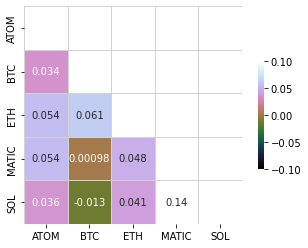

In [8]:
# Plot Covariance Matrix (Returns between assets)
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 

# Get Covariance/Correlation Matrix for Plot (use different methods)
returns = table.pct_change()
# cov_matrix_plot = returns.corr(method="kendall") #compute correlation matrix (strength and direction of relationship between X & Y)
cov_matrix_plot = returns.cov() #compute covariance matrix (measure only the direction of the relationship between X & Y)

# Generate a mask to display lower half of matrix
mask = np.triu(np.ones_like(cov_matrix_plot, dtype=bool))

# Set up the matplotlib figure size
f, ax = plt.subplots(figsize=(6, 4))

# Plot Heatmap with Masked Vals and Gridlines
sns.heatmap(cov_matrix_plot, mask=mask, cmap="cubehelix", center=0, vmin=-.1, vmax=.1, annot=True,
            square=True, linewidths=1, linecolor="lightgrey", cbar_kws={"shrink": .5})

In [5]:
# Forward Selection of Assets w MPT

# User Defined Vars
update_threshold = 30 #number of simulation rounds before holding current best allocation assets constant
n_assets = 2 #number of assets to sample for portfolio, start w more than a single one
max_rounds = 500 #per "seed" asset


# Run Forward Selection on Table w Specified Vars
msr, allocation = forwardSelection(table, update_threshold, n_assets, max_rounds)

# Summary Info
allocation

2 for - ATOM
# of Assets in Portfolio- 3
Asset Tickers- Index(['BTC', 'SOL', 'ATOM'], dtype='object')
Change # 1 to Global Optima
Assets- ['BTC', 'SOL', 'ATOM']
Alloca- [[0.48 0.25 0.27]]
Return- 9.933171925323807
stddev- 4.0868341819428995



1 for - BTC
# of Assets in Portfolio- 3
Asset Tickers- Index(['ATOM', 'SOL', 'BTC'], dtype='object')
Change # 1 to Global Optima
Assets- ['ATOM', 'SOL', 'BTC']
Alloca- [[0.25 0.24 0.51]]
Return- 6.266946960204951
stddev- 3.3011729991911882



3 for - ETH
# of Assets in Portfolio- 3
Asset Tickers- Index(['BTC', 'MATIC', 'ETH'], dtype='object')
Change # 1 to Global Optima
Assets- ['BTC', 'MATIC', 'ETH']
Alloca- [[0.7  0.25 0.05]]
Return- 9.413794801411033
stddev- 3.8589148818834116



1 for - MATIC
# of Assets in Portfolio- 3
Asset Tickers- Index(['BTC', 'SOL', 'MATIC'], dtype='object')
Change # 1 to Global Optima
Assets- ['BTC', 'SOL', 'MATIC']
Alloca- [[0.68 0.25 0.06]]
Return- 7.68742400936304
stddev- 3.408965090689451



1 for - SOL
# of Assets

,BTC,ETH,SOL
allocation,0.58,0.0,0.41
